# **Прогноз курса доллара США к рублю на основе данных за 2017-2019 гг.**
## **Интенсив 16-18 апреля 2020 от SkillBox.ru**

## **Подключение, загрузка и краткий обзор данных**

Подключение Google Drive и прочие вещи, которые не понадобились бы, если бы у меня на комп встала Anaconda без этих ваших предложений "скачайте PyCharm for Anaconda, но фиг вам, а не Jupiter Notebook для Community Edition".

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
working_path = "/content/drive/My Drive/"

Подключение Pandas

In [ ]:
import pandas as pd

Загрузка данных из файла с курсом доллара США за два года и их краткий обзор

In [ ]:
usd_rates = pd.read_excel(working_path + "usd_rates.xlsx")

In [ ]:
usd_rates.head(3)

,nominal,data,curs,cdx
0,1,2017-01-10,59.8961,Доллар США
1,1,2017-01-11,59.9533,Доллар США
2,1,2017-01-12,60.1614,Доллар США


In [ ]:
usd_rates.describe()

,nominal,curs
count,740.0,740.000000
mean,1.0,61.944060
std,0.0,3.686500
min,1.0,55.671700
25%,1.0,58.315175
50%,1.0,62.762550
75%,1.0,65.217975
max,1.0,69.974400


Из приведённого описания датасета мы видим, что за два года курс доллара у нас колебался от 55.67 до 69.97 рублей за доллар, среднее 61.94, медиана чуть больше - 62.76, что может значить, что относительно высокие значения курса были более умеренные, чем какие-то резкие выбросы вниз. Но в целом они близки.

График курса доллара США за 2 года:

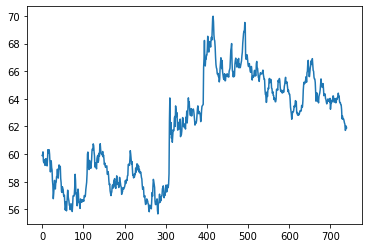

In [ ]:
usd_rates.curs.plot()

## **Подготовка данных к моделированию**

Уберём всю лишнюю информацию, оставив только значения курса USD:

In [ ]:
money = usd_rates.curs

Определим основные параметры нашего прогноза:
*   **PAST** - число дней, на которых основан наш прогноз
*   **FUTURE** - число дней, на которое мы делаем прогноз (наши целевые значения)

In [ ]:
PAST = 28
FUTURE = 7

Посчитаем, сколько нам доступно примеров при заданных параметрах прогноза

In [ ]:
start = PAST
end = len(money) - FUTURE
count = len(money)
print(f"Всего у нас {count} значений USD по дням, мы рассмотрим дни с {start} по {end}")

Всего у нас 740 значений USD по дням, мы рассмотрим дни с 28 по 733


Начнём формировать набор данных для обучения моделей. Для этого мы должны сформировать DataFrame размером *(end-start)* строк и *(PAST+FUTURE)* столбцов, в котором каждая строка будет элементом выборки, подающейся на вход обучающейся модели.

Данные для заполнения:

In [ ]:
table = []
for i in range(start, end):
    s = money[(i-PAST):(i+FUTURE)]
    table.append(list(s))

Структура столбцов:

In [ ]:
past_columns = []
for i in range(PAST):
    past_columns.append(f"past_{i}")

In [ ]:
future_columns = []
for i in range(FUTURE):
    future_columns.append(f"future_{i}")

Формирование рабочего DataFrame:

In [ ]:
df_course = pd.DataFrame(table, columns=(past_columns+future_columns))

Убедимся, что данные заполнены, а структура соответствует заявленной:

In [ ]:
df_course.head(3)

,past_0,past_1,past_2,past_3,past_4,past_5,past_6,past_7,past_8,past_9,past_10,past_11,past_12,past_13,past_14,past_15,past_16,past_17,past_18,past_19,past_20,past_21,past_22,past_23,past_24,past_25,past_26,past_27,future_0,future_1,future_2,future_3,future_4,future_5,future_6
0,59.8961,59.9533,60.1614,59.4978,59.3700,59.6067,59.4015,59.1830,59.3521,59.6697,59.5034,59.2168,59.1489,59.6356,60.3196,60.1618,60.0851,60.3099,59.9858,59.3137,58.7121,59.1933,59.5129,59.0235,58.8457,58.0619,57.7388,56.7719,57.1507,57.6342,58.0967,57.8590,57.4762,57.9371,57.9627
1,59.9533,60.1614,59.4978,59.3700,59.6067,59.4015,59.1830,59.3521,59.6697,59.5034,59.2168,59.1489,59.6356,60.3196,60.1618,60.0851,60.3099,59.9858,59.3137,58.7121,59.1933,59.5129,59.0235,58.8457,58.0619,57.7388,56.7719,57.1507,57.6342,58.0967,57.8590,57.4762,57.9371,57.9627,58.3776
2,60.1614,59.4978,59.3700,59.6067,59.4015,59.1830,59.3521,59.6697,59.5034,59.2168,59.1489,59.6356,60.3196,60.1618,60.0851,60.3099,59.9858,59.3137,58.7121,59.1933,59.5129,59.0235,58.8457,58.0619,57.7388,56.7719,57.1507,57.6342,58.0967,57.8590,57.4762,57.9371,57.9627,58.3776,58.4067


Разделим все имеющиеся данные на обучающую и тестовую выборки:

Обучающая выборка:

In [ ]:
X = df_course[past_columns][:-10]
Y = df_course[future_columns][:-10]

Тестовая выборка, на которой будет происходить проверка:

In [ ]:
X_test = df_course[past_columns][-10:]
Y_test = df_course[future_columns][-10:]

## **Обучение нейронных сетей из sklearn**

Для начала повторим то, что было получено в эфире:

In [ ]:
from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(hidden_layer_sizes=(100,100,100,100), max_iter=2000, random_state=42)
MLP.fit(X,Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

Построим графики, используя MAE для оценки качества модели:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

Сохраним полученные значения ошибок для более точного сравнения моделей:

Day #0, error = 0.8222857466577237


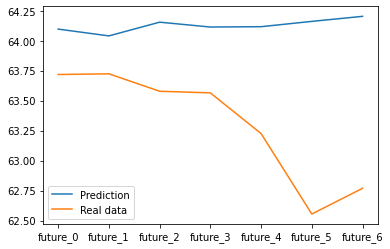

Day #1, error = 0.9329295040445525


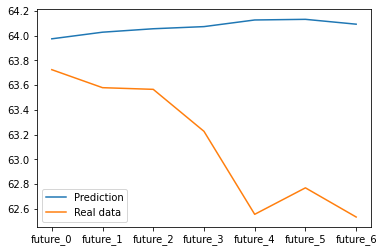

Day #2, error = 1.1381040836768344


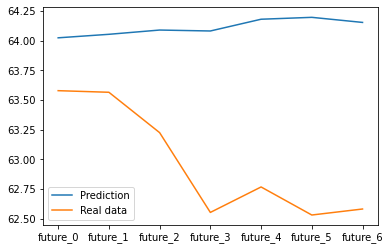

Day #3, error = 1.2418902068202737


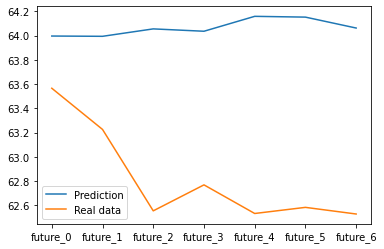

Day #4, error = 1.4014577848963827


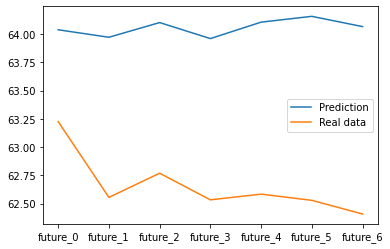

Day #5, error = 1.4297240000488896


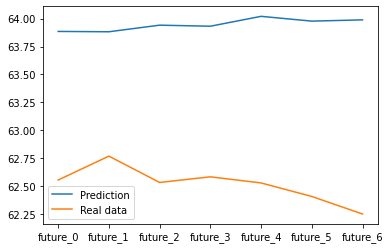

Day #6, error = 1.3707402476848836


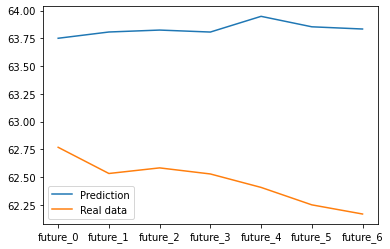

Day #7, error = 1.5464698102490186


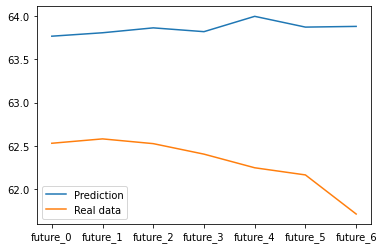

Day #8, error = 1.4547624278296192


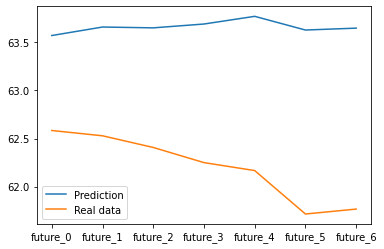

Day #9, error = 1.4427342564532577


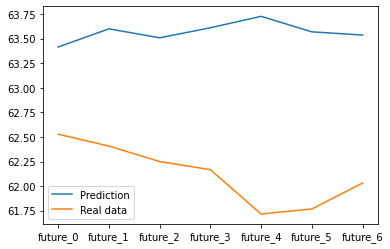

In [ ]:
errs_base = []
for i in range(10):
    prediction = MLP.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    errs_base.append(err)
    print(f"Day #{i}, error = {err}")

    plt.plot(prediction[0], label="Prediction")
    plt.plot(Y_test.iloc[i], label="Real data")
    plt.legend()
    plt.show()

In [ ]:
errs_base

[0.8222857466577237,
 0.9329295040445525,
 1.1381040836768344,
 1.2418902068202737,
 1.4014577848963827,
 1.4297240000488896,
 1.3707402476848836,
 1.5464698102490186,
 1.4547624278296192,
 1.4427342564532577]

Задача - подобрать такие параметры для MLPRegressor, чтобы уменьшить значения MAE.

Изменим выбранную архитектуру нейронной сети.

Оценивать результаты будем по разнице между ошибками МАЕ при базовой и выбранной архитектуре для каждого примера.

Для начала уберём один из внутренних слоёв, оставив всё остальное прежним.

In [ ]:
MLP_shallow = MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=2000, random_state=42)
MLP_shallow.fit(X,Y)
derrs_shallow = []
for i in range(10):
    prediction = MLP_shallow.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    derrs_shallow.append(err-errs_base[i])

derrs_shallow

[-0.35612777140836527,
 -0.3579039889156549,
 -0.4187607237740991,
 -0.417252999480887,
 -0.40373074050156943,
 -0.4281723553155701,
 -0.40324521546870584,
 -0.4597359248406241,
 -0.40657208764024744,
 -0.42626437638220405]

Как видим, уже один убранный внутренний слой сети улучшил точность прогноза в среднем на 40 копеек. Однако мы помним, что разницу в те же 40 копеек в эфире можно было получить, просто изменив random_state. Попробуем добиться более существенных улучшений прогноза.

Попробуем изменить число нейронов в скрытых слоях и уберём ещё один слой:

In [ ]:
MLP_cascade = MLPRegressor(hidden_layer_sizes=(256,128), max_iter=2000, random_state=42)
MLP_cascade.fit(X,Y)
derrs_cascade = []
for i in range(10):
    prediction = MLP_cascade.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    derrs_cascade.append(err-errs_base[i])

derrs_cascade

[-0.4349084497088316,
 -0.4370135235695136,
 -0.5481717498203744,
 -0.5775703838927394,
 -0.7001898866796848,
 -0.6750776739718884,
 -0.7461439441609465,
 -0.9130697867100038,
 -0.8636885302975809,
 -0.8883652596535958]

Построим графики по дням для этой архитектуры:

Day #0, error = 0.3873772969488921


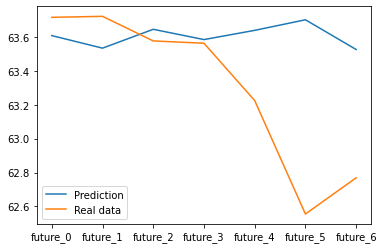

Day #1, error = 0.49591598047503893


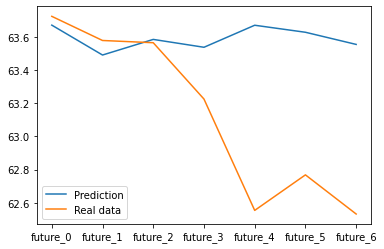

Day #2, error = 0.5899323338564599


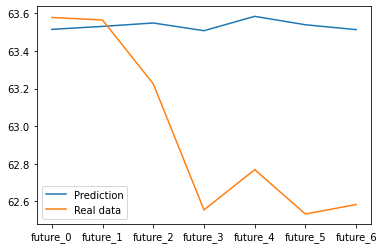

Day #3, error = 0.6643198229275343


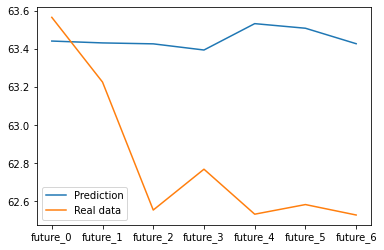

Day #4, error = 0.7012678982166979


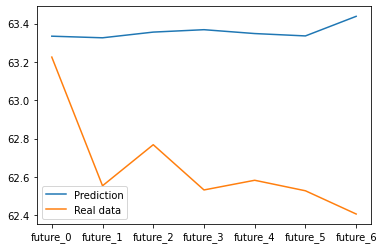

Day #5, error = 0.7546463260770011


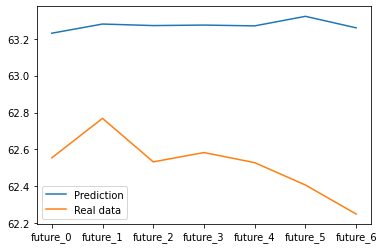

Day #6, error = 0.624596303523937


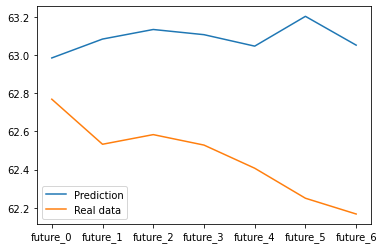

Day #7, error = 0.6334000235390148


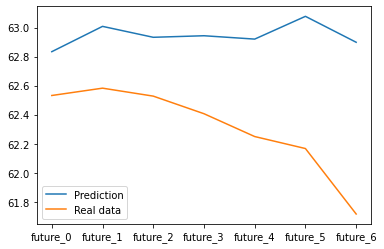

Day #8, error = 0.5910738975320383


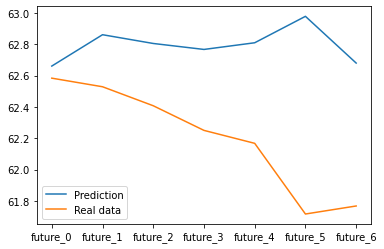

Day #9, error = 0.5543689967996619


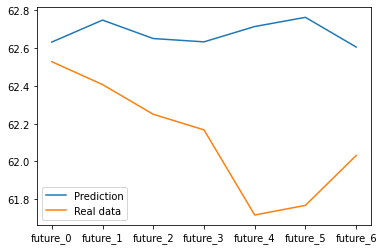

In [ ]:
for i in range(10):
    prediction = MLP_cascade.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    print(f"Day #{i}, error = {err}")

    plt.plot(prediction[0], label="Prediction")
    plt.plot(Y_test.iloc[i], label="Real data")
    plt.legend()
    plt.show()

Как видим, такой прогноз гораздо точнее, но в абсолютных значениях он всё равно достаточно велик. Тем не менее, поставленная задача уже на этом этапе выполнена.

Проиллюстрируем влияние архитектуры нейросети на величину МАЕ в этом примере.

Сначала приведём значения ошибок для разных вариантов архитектуры к абсолютным значениям:

In [ ]:
errs_shallow = [derr + errs_base[i] for i, derr in enumerate(derrs_shallow)]
errs_cascade = [derr + errs_base[i] for i, derr in enumerate(derrs_cascade)]

Для наглядности и удобства сравнения построим график:

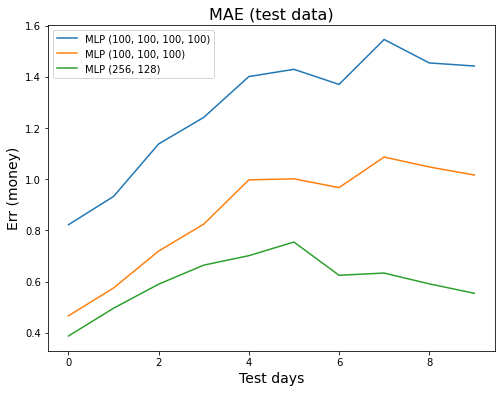

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("MAE (test data)", fontsize=16)
ax.set_xlabel("Test days", fontsize=14)        
ax.set_ylabel("Err (money)", fontsize=14)
ax.plot(errs_base, label="MLP (100, 100, 100, 100)")
ax.plot(errs_shallow, label="MLP (100, 100, 100)")
ax.plot(errs_cascade, label="MLP (256, 128)")
ax.legend()
plt.show()

## **Обучение трёх других регрессоров из sklearn**

Проведём обучение следующих ранее не рассмотренных моделей:


1.   **GaussianProcessRegressor**
2.   **ExtraTreeRegressor**
3.   **MultiOutputRegressor + GradientBoostingRegressor**

### **GaussianProcessRegressor**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.00001, random_state=42).fit(X, Y)

Day #0, error = 0.5047807264385469


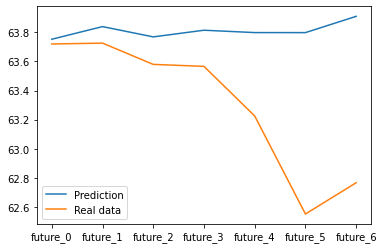

Day #1, error = 0.6424822311115536


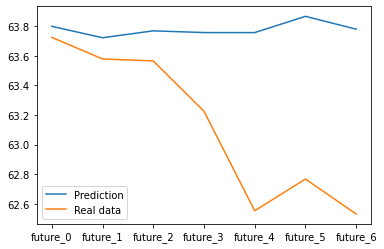

Day #2, error = 0.7392297789752637


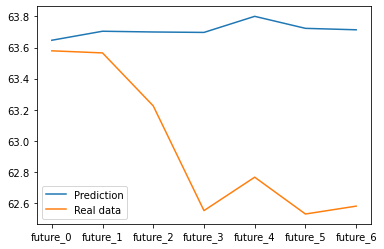

Day #3, error = 0.8134807822687671


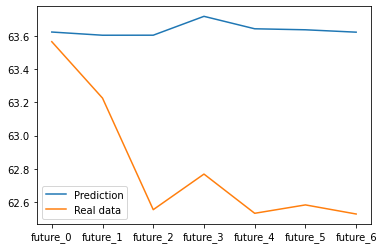

Day #4, error = 0.9589686934398541


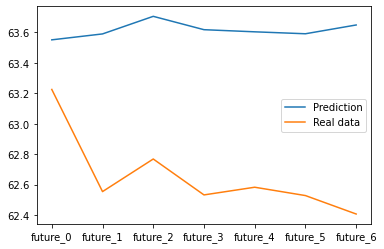

Day #5, error = 0.7304039490008724


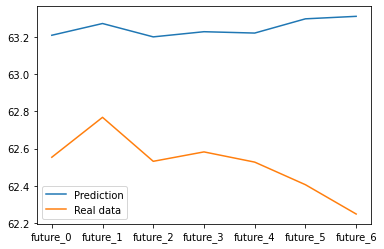

Day #6, error = 0.24480948058942534


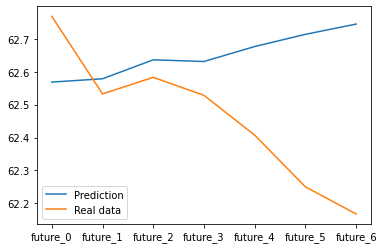

Day #7, error = 0.5739396310587281


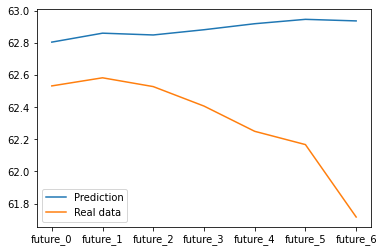

Day #8, error = 0.45113790972687234


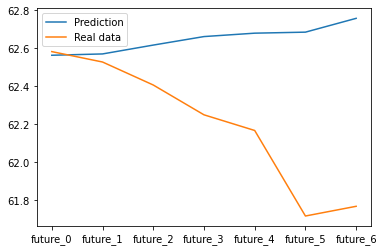

Day #9, error = 0.5968081786693874


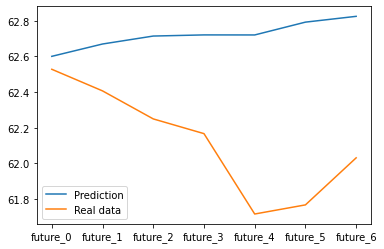

In [ ]:
errs_gpr = []
for i in range(10):
    prediction = gpr.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    errs_gpr.append(err)
    print(f"Day #{i}, error = {err}")

    plt.plot(prediction[0], label="Prediction")
    plt.plot(Y_test.iloc[i], label="Real data")
    plt.legend()
    plt.show()

Из значений МАЕ мы видим, что даже минимально настроенный регрессор, построенный на распределении Гаусса, даёт результаты лучше, чем нейросеть, построенная в эфире.

### **ExtraTreeRegressor**

Day #0, error = 0.5158714285714286
Day #1, error = 0.6852857142857138
Day #2, error = 0.8483285714285712
Day #3, error = 2.053514285714282


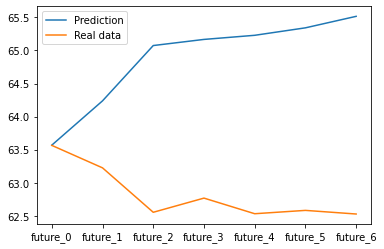

Day #4, error = 1.1638571428571427
Day #5, error = 1.3032571428571436
Day #6, error = 0.5383642857142864
ETR MAE (0.5383642857142864) is less than best MLP MAE (0.624596303523937)
Day #7, error = 0.688678571428572
Day #8, error = 0.7979642857142863
Day #9, error = 0.8767642857142864


In [ ]:
from sklearn.tree import ExtraTreeRegressor
etr = ExtraTreeRegressor(criterion='mae', max_leaf_nodes=25, max_depth=20, random_state=42)
etr.fit(X, Y)

errs_etr = []

for i in range(10):
    prediction = etr.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    errs_etr.append(err)
    print(f"Day #{i}, error = {err}")

    if err > errs_base[i]:
      plt.plot(prediction[0], label="Prediction")
      plt.plot(Y_test.iloc[i], label="Real data")
      plt.legend()
      plt.show()
    if err < errs_cascade[i]:
      print(f"ETR MAE ({err}) is less than best MLP MAE ({errs_cascade[i]})")

Для модели регрессии ExtraTreeRegressor при разнообразном значении параметров мы всё равно получаем очень плохие данные для третьего тестового дня, однако для других дней результат лучше, чем у нейронной сети, постороенной в эфире. У модифицированной нейронной сети (MLP_cascade) результат в целом выше, чем у ExtraTreeRegressor.

### **MultiOutputRegressor + GradientBoostingRegressor**

Поскольку *GradientBoostingRegressor* рассчитан на 1 целевую переменную, мы добавляем *MultiOutputRegressor* для того, чтобы была возможность использовать эту модель регрессии

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

regr_multirf = MultiOutputRegressor(GradientBoostingRegressor(random_state=42, loss='huber',learning_rate=0.0001))
regr_multirf.fit(X, Y)

errs_gbr = []
for i in range(10):
    prediction = regr_multirf.predict([X_test.iloc[i]])
    err = mean_absolute_error(prediction[0], Y_test.iloc[i])
    errs_gbr.append(err)
    print(f"Day #{i}, error = {err}")

    if err > errs_base[i]:
      plt.plot(prediction[0], label="Prediction")
      plt.plot(Y_test.iloc[i], label="Real data")
      plt.legend()
      plt.show()
    if err < errs_cascade[i]:
      print(f"ETR MAE ({err}) is less than best MLP MAE ({errs_cascade[i]})")

Day #0, error = 0.49820693404719457
Day #1, error = 0.4809696677648349
ETR MAE (0.4809696677648349) is less than best MLP MAE (0.49591598047503893)
Day #2, error = 0.45353622681204186
ETR MAE (0.45353622681204186) is less than best MLP MAE (0.5899323338564599)
Day #3, error = 0.44743871150211795
ETR MAE (0.44743871150211795) is less than best MLP MAE (0.6643198229275343)
Day #4, error = 0.456445798303539
ETR MAE (0.456445798303539) is less than best MLP MAE (0.7012678982166979)
Day #5, error = 0.5244531988414026
ETR MAE (0.5244531988414026) is less than best MLP MAE (0.7546463260770011)
Day #6, error = 0.5797531988414032
ETR MAE (0.5797531988414032) is less than best MLP MAE (0.624596303523937)
Day #7, error = 0.7300674845556888
Day #8, error = 0.8393531988414031
Day #9, error = 0.9181531988414032


Использование *GradientBoostingRegressor* с небольшими настройками позволило в половине случаев улучшить результат по метрике MAE, полученный для MLP с настроенной архитектурой.

## **Выводы**

1. Даже классические алгоритмы машинного обучения, имеющиеся в sklearn, зачастую позволяют получить приемлемую точность результатов.
2. Без чёткого понимания, что такое "приемлемая точность", начинается какой-то довольно дурацкий подбор параметров, которой наверняка автоматизирован (например, grid_search, который я не использовала в этом jupiter-notebook)
3. Нужно довольно приличное знание алгоритмов и статистики, чтобы не тыкаться с этими параметрами вслепую.
4. Можно вывести графики полученных МАЕ для MLP и трёх других моделей регрессии, чтобы понять, на сколько в среднем мы ошибаемся с прогнозами курса доллара США.

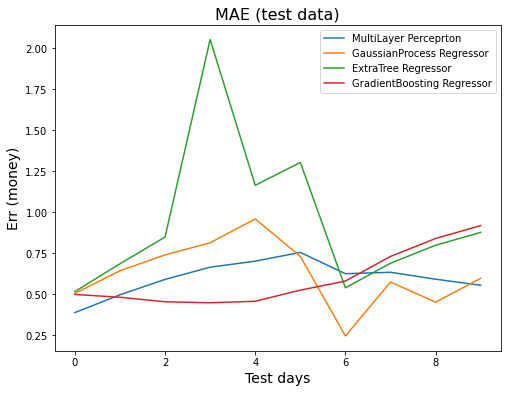

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("MAE (test data)", fontsize=16)
ax.set_xlabel("Test days", fontsize=14)        
ax.set_ylabel("Err (money)", fontsize=14)
ax.plot(errs_cascade, label="MultiLayer Perceprton")
ax.plot(errs_gpr, label="GaussianProcess Regressor")
ax.plot(errs_etr, label="ExtraTree Regressor")
ax.plot(errs_gbr, label="GradientBoosting Regressor")
ax.legend()
plt.show()